In [15]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [42]:
# directory for data
dataroot = "./data/"

# number of workers for dataloaders
workers = 2

# batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer
image_size = 64

# number of channels in image
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# size of feature maps in generator
ngf = 64

# size of feature maps in discriminator
ndf = 64

# number of training epochs
num_epochs = 5

# learning rate
learning_rate = 0.0022

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0

In [43]:
# We cann use the entire dataset folder using ImageFolder
# creates dataset
dataset = dset.ImageFolder(root=dataroot, 
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                           ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# choose which device to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

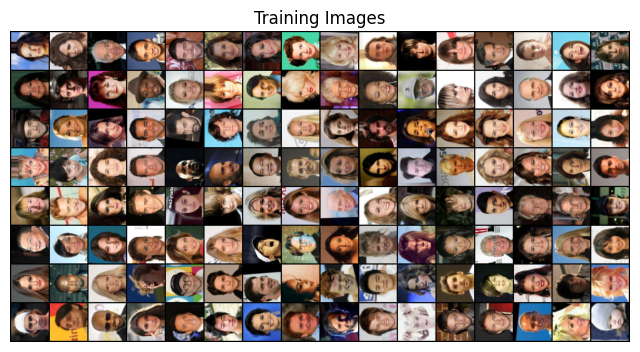

In [44]:
# plot some images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0], padding=2, normalize=True).cpu()))
plt.show()

In [45]:
# From DCGAN paper, model weights need to be randomly initialized from a normal distribution that has a mean=0 and stdev=0.02.
# custom weights initialization called on "netG" and "netD"
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Batchname') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# The function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet normal distrib criteria

In [50]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()       # initializes itself (VERY IMPORTANT)

        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size: (ngf * 8) x 4 x4
            nn.ConvTranspose2d(nz, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size: (ngf * 4) x 8 x 8
            nn.ConvTranspose2d(nz, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size: (ngf * 2) x 16 x 16
            nn.ConvTranspose2d(nz, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size: (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size: (nc) x 64 x 64
        )

    def forward(self, input):
            return self.main(input)

In [52]:
# Now we can instantiate the generator and apply the weights_init function
# create the model
netG = Generator(ngpu).to(device)

# handle multi-gpu if desired
if ((device.type == 'cuda') and (ngpu > 1)):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the "weights_init" function to randomly initialize all weights to mean=0, stdev=0.02
netG.apply(weights_init)

# prints the generator model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(100, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [55]:
# discriminator (pretty much reverse of generator)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()            # initializes itself (VERY IMPORTANT)

        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is a vector of shape: (nc) x 64 x 64
            nn.Conv2d(ngf, nc, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # input shape: (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # input shape: (ndf * 2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # input shape:ret (ndf * 4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # input shape: (ndf) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=True),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

In [57]:
# Now we can instantiate the discriminator and apply the weights_init function
netD = Discriminator(ngpu).to(device)

# handle multi-gpu if needed
if ((device.type == 'cuda') and (ngpu > 1)):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the "weights_init" function to randomly initialize all weights to mean=0, stdev=0.02
netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)
